# Delay Calculation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle
from astropy import units as u
from astropy.time import Time
import matplotlib as mpl

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

## Delay Calculation

I'll start by focusing on the equations involved instead of the actually making this relatistic. I'll add an arbitrary pointing for the telescopes in the array before I focus on things like actual source position in the sky relative to the telescope.

$$ \textbf{y} \left[n \right] = \sum_{i = 0}^{N-1} \textbf{a}^{H}_{i} \textbf{x}_i \left[n \right]$$

Here, $n$ is the $n$-th time sample, $N$ is the number of array elements, $\textbf{x}_i \left[ n \right]$ is the $n$-th sample of the $i$-th antenna, $\textbf{a}^{H}_{i}$ is the so-called steering vector and $\textbf{y}_i \left[ n \right]$ is the $n$-th beamformed sample.


$$ \textbf{a}^{H}_i = \exp \left( {-j \varphi_i} \right)$$

$$ \varphi_i = \frac{2 \pi f_0}{c} \left( X_i \cos \phi \sin \theta + Y_i \sin \phi \sin \theta + Z_i \cos \theta \right)$$

Reference:

https://pdfs.semanticscholar.org/0bb2/d569d781bd7262d87efd9fc32548f24bcece.pdf

Start with a grid of 100 elements. I'll set the $Z$ component to 0 to make things easy

This steering vector can then be used to phase amplitude and phase data from each telescope to digitally point the telescope if the bandwidth used is small enough. If the bandwidth is not small compared to the delay across the aperature, this method does not completely work.

In [3]:
def calc_delay(ant_pos, p_az, p_polar, az, polar):
    """asdf
    
    ant_pos: (np.ndarray)
        asdf
    freqs: (float)
        Frequency
    az: (float)
        Azimuth to beamform to
    polar: (float)
        
    """
    c = 3e8
    
    p_delay = (ant_pos[0] * np.cos(p_az) * np.sin(p_polar) + \
               ant_pos[1] * np.sin(p_az) * np.sin(p_polar) + \
               ant_pos[2] * np.cos(p_polar))
    
    s_delay = (ant_pos[0] * np.cos(az) * np.sin(polar) + \
               ant_pos[1] * np.sin(az) * np.sin(polar) + \
               ant_pos[2] * np.cos(polar))
    
    tau = (s_delay - p_delay) / c
    
    return tau

def calc_weights(freqs, delay):
    if np.array(freqs).shape[0] == 1:
        phase = 2.0 * np.pi * freqs * delay
    
    else:
        phase = 2.0 * np.pi * freqs * delay[:, np.newaxis]
        
    return np.exp(-1j * phase)

def box_filter(c_ra, c_dec, beam_rad):
    """http://janmatuschek.de/LatitudeLongitudeBoundingCoordinate

    """
    if c_dec - beam_rad <= - np.pi / 2.0:
        ra_min, ra_max = 0.0, 2.0 * np.pi
        dec_min = -np.pi / 2.0
        dec_max = c_dec + beam_rad

    elif c_dec + beam_rad >= np.pi / 2.0:
        ra_min, ra_max = 0.0, 2.0 * np.pi
        dec_min = c_dec - beam_rad
        dec_max = np.pi / 2.0

    else:
        ra_offset = np.arcsin( np.sin(beam_rad) / np.cos(c_dec))
        ra_min  = c_ra - ra_offset
        ra_max  = c_ra + ra_offset
        dec_min = c_dec - beam_rad
        dec_max = c_dec + beam_rad

    return ra_min, ra_max, dec_min, dec_max

In [7]:
def calc_delay(ant_pos, p_az, p_polar):
    """asdf
    
    ant_pos: (np.ndarray)
        asdf
    freqs: (float)
        Frequency
    az: (float)
        Azimuth to beamform to
    polar: (float)
        
    """
    c = 3e8
    
    p_delay = (ant_pos[0] * np.cos(p_az) * np.sin(p_polar) + \
               ant_pos[1] * np.sin(p_az) * np.sin(p_polar) + \
               ant_pos[2] * np.cos(p_polar))
    
    return p_delay / c

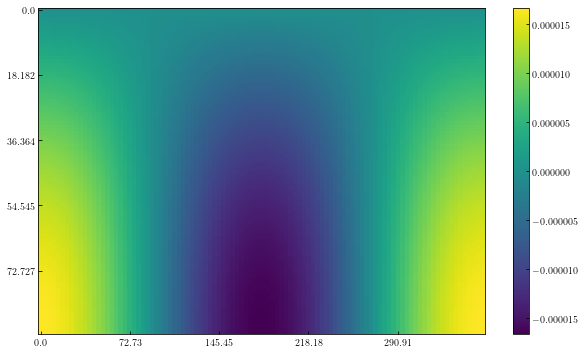

In [12]:
ant = [5000, 0, 0]
az = np.linspace(0, 2*np.pi, 100)
polar = np.linspace(0, np.pi / 2.0, 100)
p_az, p_polar = np.meshgrid(az, polar)
delay = calc_delay(ant, p_az, p_polar)
plt.figure(figsize=(10,6))
plt.imshow(delay, aspect='auto')
plt.xticks(np.arange(0,100,20), np.round(np.rad2deg(az[np.arange(0,100,20)]), 2))
plt.yticks(np.arange(0,100,20), np.round(np.rad2deg(polar[np.arange(0,100,20)]), 3))
plt.colorbar()
plt.show()

In [4]:
def az_alt(source, times):
    """Transform from ra/dec coords to alt/az from MeerKATs perspective
    
    Args:
        source: (astropy.coordinates.SkyCoord)
            SkyCoord object with coordinates for an object or objects
        times: (astropy.time.Time)
            Observation time(s)
            
    Returns:
        az: (astropy.coordinates.angles.Longitude)
            Azimuth coordinate list with shape (N_times x N_sources)
        alt: (astropy.coordinates.angles.Latitude)
            Altitude coordinate list with shape (N_times x N_sources)
    """
    mk_loc = _meerkat_location()
    meerkat_frame = AltAz(obstime = times, location=mk_loc)
    frame = source.transform_to(meerkat_frame)
    return frame

In [5]:
def _meerkat_location():
    meerkat_pos = (-30.721111, 21.411111)
    loc_meerkat = EarthLocation(lat = meerkat_pos[0]*u.deg, lon = meerkat_pos[1]*u.deg)
    return loc_meerkat

In [6]:
def az_alt_to_ra_dec(az, alt, time = Time.now(), loc = _meerkat_location()):
    """Function for testing delay calculation
    """
    coord = SkyCoord(az = az, alt = alt, unit=(u.deg), frame='altaz', location = loc, obstime = Time.now())
    return coord.icrs.ra, coord.icrs.dec

Azimuth starts at North in astropy. However, the equation above gives a maximum delay when the azimuthal angle is 0 degrees, which means that x is aligned with North/South. I'll need to look into this to see if this is a problem.

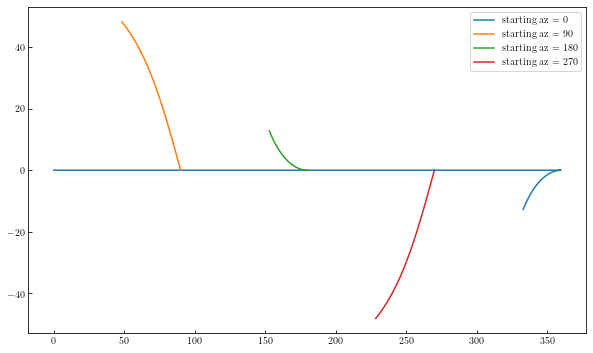

In [21]:
plt.figure(figsize=(10,6))

start_time = Time.now()
obs_times = start_time + np.linspace(0, 4, 200) * u.hour
for i in [0, 90, 180, 270]:
    p_ra, p_dec = az_alt_to_ra_dec(i, 0.)
    source = SkyCoord(p_ra, p_dec)
    coords = az_alt(source, obs_times)
    plt.plot(coords.az, coords.alt, label='starting az = {}'.format(i))
    
plt.legend()
plt.show()

## Example Array

In [59]:
ant_pos = [0, 5000, 0] # Array where two elements are aligned in the east/west direction
start_time = Time.now()
obs_times = start_time + np.linspace(0, 5, 100) * u.minute
p_alt = np.deg2rad(85.0)
p_az = np.deg2rad(90.0)
p_ra, p_dec = az_alt_to_ra_dec(az = np.rad2deg(p_az), alt = np.rad2deg(p_alt))
coord = az_alt(SkyCoord(p_ra, p_dec), obs_times)

azL, azR, altL, altR = box_filter(coord[0].az.rad, coord[0].alt.rad, np.deg2rad(0.5))
s_az = np.linspace(azL, azR, 100)
s_alt = np.linspace(altL, altR, 100)
S_az, S_alt = np.meshgrid(s_az, s_alt)
delay = calc_delay(ant_pos, coord[0].az.rad, np.pi/2.0 - coord[0].alt.rad, S_az, np.pi/2.0 - S_alt)
data_cube = np.flip(delay, axis=0)

for i, c in enumerate(coord[1:]):
    azL, azR, altL, altR = box_filter(c.az.rad, c.alt.rad, np.deg2rad(0.5))
    s_az = np.linspace(azL, azR, 100)
    s_alt = np.linspace(altL, altR, 100)
    S_az, S_alt = np.meshgrid(s_az, s_alt)
    delay = calc_delay(ant_pos, c.az.rad, np.pi/2.0 - c.alt.rad, S_az, np.pi/2.0 - S_alt)
    data_cube = np.dstack([data_cube, np.flip(delay, axis = 0)])

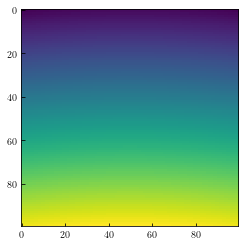

In [60]:
plt.imshow(data_cube[:, :, 0])

In [61]:
idx1, idx2 = np.where(np.abs(data_cube[:, :, 1] - data_cube[:, :, -1]) ==
                      np.abs(data_cube[:, :, 1] - data_cube[:, :, -1]).max())

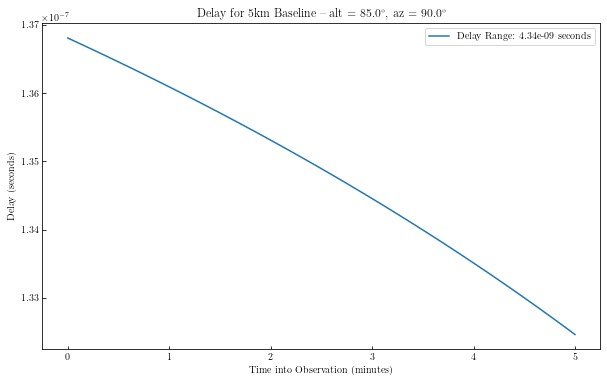

In [63]:
legend = 'Delay Range: {:.2e} seconds'.format(np.abs(data_cube[idx1[0], idx2[0], -1] - data_cube[idx1[0], idx2[0], 0]))

plt.figure(figsize=(10,6))
plt.plot(np.linspace(0, 5, 100), data_cube[idx1[0], idx2[0], :], label=legend)
plt.xlabel('Time into Observation (minutes)')
plt.ylabel('Delay (seconds)')
plt.title('Delay for 5km Baseline -- alt = {}$^\circ$, az = {}$^\circ$'.format(85.0, 90.0))
plt.legend()
plt.savefig('delay_alt_85_az_90_5km_5min.png')

In [32]:
x = np.linspace(20, 5000, 100)
ant_pos = np.column_stack([x, np.zeros_like(x), np.zeros_like(x)])

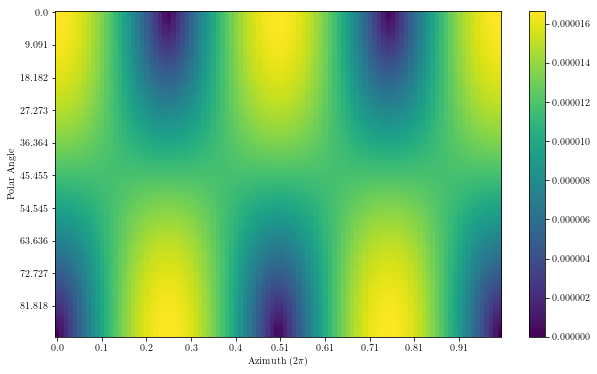

In [244]:
phi = np.linspace(0, 2*np.pi, 100)
theta = np.linspace(0, np.pi / 2.0, 100)

P, T = np.meshgrid(phi, theta)

plt.figure(figsize=(10,6))
plt.imshow(d_delay(5000, P, T), aspect='auto')
plt.xticks(np.arange(0,100,10), np.round(phi[np.arange(0,100,10)] / (2 * np.pi), 2))
plt.yticks(np.arange(0,100,10), np.round(np.rad2deg(theta[np.arange(0,100,10)]), 3))
plt.xlabel(r'Azimuth (2$\pi$)')
plt.ylabel('Polar Angle')
plt.colorbar()
plt.show()

In [60]:
a, _ = np.meshgrid(np.linspace(0, 10, 10), np.array([0, 2]))